> **Note:** This notebook is my personal practice notebook on Feedforward neural language model
>  
> I’m following along with the course materials and using ideas/code inspired by:
> 
> - [CMU ANLP Course Page](https://cmu-l3.github.io/anlp-spring2025/)  
>   *(Lecture 4: Recurrent Neural Networks, Spring 2025)*  

## Notebook Outline

1. [Dataset Preparation ](#dataset-preparation)
2. [Understanding Attention](#understanding-attention)
3. [Creating Encoder Decoder Architecture](#creating-encoder-decoder-architecture)
4. [Training](#Training)
5. [Generation](#generation)
6. [Visualize Attention](#visualize-attention)
7. [Saving the Model](#saving-the-model)

In [64]:
# Imports
import random
import torch

from torch import nn
from torch.nn import functional as F
from torch import optim
from typing import List, Dict, Tuple

random.seed(123)

#### Dataset Preparation 

Task: reversing names

Our task will be to reverse a name, e.g.:

    sophia -> aihpos

To make the model learn an additional simple pattern, we'll also add a noise character after each character of the input, e.g.:

    suorpxhziwa -> aihpos

As a spoiler, we'll be able to see the model attending to non-noise characters.

In [65]:
# Understanding the data
data = open('names.txt').read().splitlines()
print(data[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [66]:
token_to_index = {tok: i for i, tok in enumerate('abcdefghijklmnopqrstuvwxyz')}

# Start/stop token
token_to_index['[S]'] = 26

# Padding token
token_to_index['[PAD]'] = 27

index_to_token = {i: tok for tok, i in token_to_index.items()}

In [67]:
# Creating the Dataset class
# Our dataset consists of x, y pairs, where x is a (n-1) token context and y is a token

class Dataset:
    """
    Dataset class for building context-target pairs from a sequence of tokens.
    """
    def __init__(self, token_to_index:Dict[str, int]):
        self.token_to_index = token_to_index

    def build_dataset(self, data:List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Build the dataset of context-target pairs.

        Args:
            data (List[str]): List of string sequences.
        """ 
        X, Yin, Yout = [], [], []
        for item in data:
            x_tokens = []
            for token in item:
                x_tokens.append(token)
                x_tokens.append(random.choice('abcdefghijklmnopqrstuvwxyz')) # Adding noise token
            y_tokens = ['[S]'] + list(reversed(item)) + ['[S]']

            x_indices = [token_to_index[token] for token in x_tokens]
            y_indices = [token_to_index[token] for token in y_tokens]

            X.append(x_indices)
            Yin.append(y_indices[:-1])
            Yout.append(y_indices[1:])
        return X, Yin, Yout

In [68]:
random.shuffle(data)

n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))

dataset = Dataset(token_to_index)
x_train, y_in_train, y_out_train = dataset.build_dataset(data[:n1])
x_dev, y_in_dev, y_out_dev = dataset.build_dataset(data[n1:n2])
x_test, y_in_test, y_out_test = dataset.build_dataset(data[n2:])
len(x_train), len(y_in_train), len(y_out_train)

(25626, 25626, 25626)

#### Understanding Attention

In [71]:
class DotAttention(nn.Module):
    def __init__(self):
        super(DotAttention, self).__init__()

    def forward(self, query, keys, values):
        # query: (B, Ty, D)
        # keys: (B, Tx, D)
        # values: (B, Tx, D) 
        dot = torch.bmm(keys, query.transpose(1, 2))
        weights = torch.softmax(dot, dim=1)
        out = torch.bmm(weights.transpose(1, 2), values)
        return out, weights

In [36]:
# Understanding Attention block with random data

B, Tx, Ty, D = 1, 3, 2, 4

torch.manual_seed(0)  # reproducibility

query  = torch.randn(B, Ty, D)  # decoder hidden states
keys   = torch.randn(B, Tx, D)  # encoder hidden states
values = torch.randn(B, Tx, D)  # same shape as keys

print(f'{query=}')
print(f'{keys=}')
print(f'{values=}')

query=tensor([[[ 1.5410, -0.2934, -2.1788,  0.5684],
         [-1.0845, -1.3986,  0.4033,  0.8380]]])
keys=tensor([[[-0.7193, -0.4033, -0.5966,  0.1820],
         [-0.8567,  1.1006, -1.0712,  0.1227],
         [-0.5663,  0.3731, -0.8920, -1.5091]]])
values=tensor([[[ 0.3704,  1.4565,  0.9398,  0.7748],
         [ 0.1919,  1.2638, -1.2904, -0.7911],
         [-0.0209, -0.7185,  0.5186, -1.3125]]])


In [70]:
attention = DotAttention()

out, weights = attention(query, keys, values)
print("Output shape:", out.shape)
print("Weights shape:", weights.shape)
print("Weights:", weights)
print("Out:", out)

Output shape: torch.Size([1, 2, 4])
Weights shape: torch.Size([1, 3, 2])
Weights: tensor([[[0.3176, 0.8526],
         [0.4494, 0.0949],
         [0.2330, 0.0525]]])
Out: tensor([[[ 0.1990,  0.8632, -0.1606, -0.4152],
         [ 0.3329,  1.3241,  0.7061,  0.5167]]])


#### Creating Encoder Decoder Architecture

In [97]:
class EncoderDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(EncoderDecoder, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.encoder = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.decoder = nn.GRU(embed_size, hidden_size, batch_first=True)

        self.attention = DotAttention()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size*2, vocab_size)

    def forward(self, x, y_in):
        # encode
        x = self.embedding(x)
        henc, henc_last = self.encoder(x)

        # decode
        y_in_embed = self.embedding(y_in)
        hdec, _ = self.decoder(y_in_embed, henc_last)

        # Attention
        query = self.query(hdec)
        context, _ =self.attention(query, henc, henc)

        # combine
        out = torch.cat([hdec, context], dim=2)
        out = self.out(out)
        return out
    
    def generate(self, x, max_len=20):
        # encode
        x_embed = self.embedding(x)
        henc, h = self.encoder(x_embed)

        # Initialize with start token
        token = torch.tensor([[token_to_index['[S]']]]).to(x.device)

        result = []
        attentions = []

        for _ in range(max_len):
            token_embed = self.embedding(token)
            hdec, h = self.decoder(token_embed, h) # first time it takes the hidden state from encoder. Next time onwards, last hidden it takes it from the decoder.

            # Attention
            query = self.query(hdec)
            context, scores = self.attention(query, henc, henc)

            # Output
            out = torch.cat([hdec, context], dim=2)
            out = self.out(out)

            # Select next token (greedy decoding)
            token = torch.argmax(out, dim=2)
            result.append(token.item())
            attentions.append(scores)

            if token[0].item() == token_to_index['[S]']:
                break

        return result, attentions

#### Training

In [92]:
def pad_batch(x, y_in, y_out):
    '''Padding the tokens so, that it would of same length'''
    max_len_x = max(len(x_inter) for x_inter in x)
    max_len_y = max(len(y) for y in y_in)
    x_pad = torch.tensor([x_inter + [token_to_index['[PAD]']] * (max_len_x - len(x_inter)) for x_inter in x])
    y_in_pad = torch.tensor([y + [token_to_index['[PAD]']] * (max_len_y - len(y)) for y in y_in])
    y_out_pad = torch.tensor([y + [token_to_index['[PAD]']] * (max_len_y - len(y)) for y in y_out])
    return x_pad, y_in_pad, y_out_pad

xp, yip, yop = pad_batch(x_train[:3], y_in_train[:3], y_out_train[:3])
print(xp)
print(yip)
print(yop)

tensor([[ 9, 14,  0, 11, 17, 16, 17, 23,  4,  3, 11,  8, 27, 27],
        [ 3, 14,  4, 21, 11, 16, 24, 15, 11, 18,  0, 22, 27, 27],
        [ 0,  5,  3,  6,  8, 16, 11, 11,  4,  7, 13, 17,  0, 23]])
tensor([[26, 11,  4, 17, 17,  0,  9, 27],
        [26,  0, 11, 24, 11,  4,  3, 27],
        [26,  0, 13,  4, 11,  8,  3,  0]])
tensor([[11,  4, 17, 17,  0,  9, 26, 27],
        [ 0, 11, 24, 11,  4,  3, 26, 27],
        [ 0, 13,  4, 11,  8,  3,  0, 26]])


In [98]:
## Training Loop
# Defining the model
model = EncoderDecoder(vocab_size=len(token_to_index), embed_size=64, hidden_size=32)

# Hyperparameters
learning_rate = 0.001
num_epochs = 1
batch_size = 8


# Defining loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=token_to_index['[PAD]'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning schedular
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs)

# Training loop
for epoch in range(num_epochs):
    # Reshuffle the data after each batch
    perm = torch.randperm(len(x_train))
    x_train = [x_train[i] for i in perm]
    y_in_train = [y_in_train[i] for i in perm]
    y_out_train = [y_out_train[i] for i in perm]

    model.train()
    total_loss = 0
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i: i+batch_size]
        y_in_batch = y_in_train[i: i+batch_size]
        y_out_batch = y_out_train[i: i+batch_size]

        # pad batch
        x_batch, y_in_batch, y_out_batch = pad_batch(x_batch, y_in_batch, y_out_batch)

        # Forward
        outputs = model(x_batch, y_in_batch)
        outputs = outputs.view(-1, len(token_to_index))
        y_batch = y_out_batch.view(-1)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    # Scheduler step
    scheduler.step()

    avg_loss = total_loss / (len(x_train) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Evaluate validation loss
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for i in range(0, len(x_dev), batch_size):
            X_batch = x_dev[i:i+batch_size]
            Yin_batch = y_in_dev[i:i+batch_size]
            Yout_batch = y_out_dev[i:i+batch_size]
            # Pad batch 
            X_batch, Yin_batch, Yout_batch = pad_batch(X_batch, Yin_batch, Yout_batch)
            outputs = model(X_batch, Yin_batch)

            outputs = outputs.view(-1, len(token_to_index))
            Y_batch = Yout_batch.view(-1)
            loss = criterion(outputs, Y_batch)

            eval_loss += loss.item()
    avg_eval_loss = eval_loss / (len(x_dev) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_eval_loss:.4f}')

Epoch [1/1], Loss: 0.9517
Epoch [1/1], Validation Loss: 0.1825


#### Generation

In [102]:
# Generate
model.eval()
with torch.no_grad():
    for i in range(10):
        x = torch.tensor([x_test[i]])
        y, _ = model.generate(x)
        y = ''.join([index_to_token[i] for i in y])
        # Remove [S] from the end of y
        y = y.split('[S]')[0]

        # Print original and generated names
        print(data[n2+i], end=' -> ')
        print(y)
        # Check if it was reversed correctly
        correct = data[n2+i][::-1] == y
        print('Correct' if correct else 'Incorrect')
        print()

kaidence -> ecnediak
Correct

eretria -> airtere
Correct

nadiah -> haidan
Correct

price -> ecirp
Correct

naja -> ajan
Correct

masaki -> ikasam
Correct

rook -> koror
Incorrect

yanitza -> aztinay
Correct

ozzie -> eizzo
Correct

lazzaro -> orzazal
Incorrect



#### Visualize Attention

In [100]:
# Visualize attention for an example

import matplotlib.pyplot as plt

# Random example index
index = torch.randint(0, len(x_test), (1,)).item()

model.eval()
with torch.no_grad():
    x = torch.tensor([x_test[index]])
    y, attentions = model.generate(x)

    # Print original and generated names
    y = ''.join([index_to_token[i] for i in y])
    # Remove [S] from the end of y
    y = y.split('[S]')[0]
    print(data[n2+index], end=' -> ')
    print(y)

attentions = torch.cat(attentions, dim=2).squeeze().cpu().numpy()

henley -> yelneh


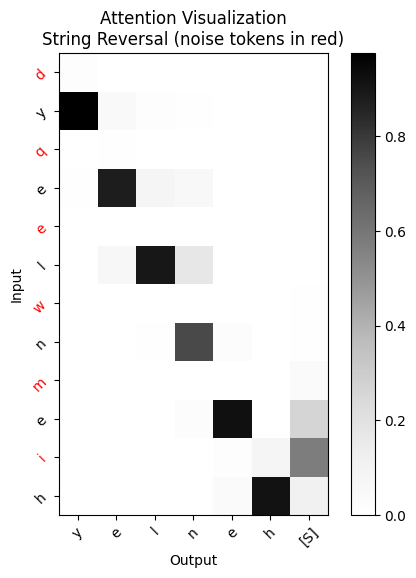

In [101]:
xtext = x_test[index]
xtext = [index_to_token[i] for i in xtext]
ytext = list(y) + ['[S]']

# Recall that each column is the attention weights for a token in the output
plt.figure(figsize=(6, 6))

plt.imshow(attentions, cmap='Greys')
# Matplot lib reverses the y-axis, so we need to reverse the labels
plt.gca().invert_yaxis()
plt.xticks(range(len(ytext)), ytext, rotation=45)

# Make the non-noise tokens blue in the yticks, and the noise tokens red
plt.yticks(range(len(xtext)), xtext, rotation=45)
for i, label in enumerate(plt.gca().get_yticklabels()):
    if i % 2 == 0:
        label.set_color('black')
    else:
        label.set_color('red')

plt.ylabel('Input')
plt.xlabel('Output')

plt.title('Attention Visualization\nString Reversal (noise tokens in red)')

plt.colorbar()
plt.savefig('attention.png', dpi=300)
# plt.show()

#### Saving the model

In [104]:
torch.save(model, 'encoder_decoder.pt')

In [107]:
model_2 = torch.load( 'encoder_decoder.pt', weights_only=False)

In [109]:
# Visualize attention for an example

import matplotlib.pyplot as plt

# Random example index
index = torch.randint(0, len(x_test), (1,)).item()

model.eval()
with torch.no_grad():
    x = torch.tensor([x_test[index]])
    y, attentions = model_2.generate(x)

    # Print original and generated names
    y = ''.join([index_to_token[i] for i in y])
    # Remove [S] from the end of y
    y = y.split('[S]')[0]
    print(data[n2+index], end=' -> ')
    print(y)

attentions = torch.cat(attentions, dim=2).squeeze().cpu().numpy()

kaedynce -> ecnydeak


In [129]:
# To visualize the model graph better converting into to ONNX
# Shapes
batch_size = 1
x_seq_len = 14
y_seq_len = 8
vocab_size = 28  # based on your max index

# Dummy x and y with random integers in [0, vocab_size)
dummy_x = torch.randint(0, vocab_size, (batch_size, x_seq_len))
dummy_y = torch.randint(0, vocab_size, (batch_size, y_seq_len))
torch.onnx.export(model, (dummy_x, dummy_y), "encoder_decoder.onnx",
                  input_names=['x','y_in'], output_names=['out'],
                  opset_version=14)

C:\Users\anilk\AppData\Local\Temp\ipykernel_28072\4183934554.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, (dummy_x, dummy_y), "encoder_decoder.onnx",
c:\Users\anilk\anaconda3\envs\torch_gpu\Lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure